In [23]:
# %load_ext autoreload
# %autoreload 2

import sys
import os

# Ajoute le dossier "src" au path
src_path = os.path.abspath("..")
if src_path not in sys.path:
    sys.path.append(src_path)
	
# Data manipulation
import pandas as pd
import numpy as np
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reducer
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin

# Models fine tuning
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import f1_score

# Custom
import importlib
from utils.result_helper import save_result, display_result
import utils.helper as helper 

## Importation of the dataset

In [40]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.StepConfig = helper.ConfigLoader.load_step1()

df_path= "../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

## Preprocessing
1. On définit les préprocessings de la donnée

In [ ]:
def emoji_processing(X: DataFrame) -> DataFrame:
	def count_emojis(text: str) -> int:
		return sum(1 for char in text if char in emoji.EMOJI_DATA)
	def replace_emojis(text: str) -> str:
		return emoji.demojize(text, delimiters=(" ", " "))
	
	X["emoji_count"] = X["text"].apply(count_emojis)
	X["text"] = X["text"].apply(replace_emojis).astype("string")
	return X
	
def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', 'url', text)
	
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link).astype("string")
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
    X["hashtag_count"] = X["text"].apply(lambda x: len(re.findall(r'#\w+', x)))
    X["text"] = X["text"].apply(lambda x: re.sub(r'#(\w+)', r'\1', x)).astype("string")
    
    return X

def mention_processing(X: DataFrame) -> DataFrame:
	def count_mentions(text: str) -> int:
		return len(re.findall(r'@\w+', text))
	
	def replace_mentions(text: str) -> str:
		return re.sub(r'@\w+', 'mention', text)

	X["mention_count"] = X["text"].apply(count_mentions)
	X["text"] = X["text"].apply(replace_mentions).astype("string")
	return X

def number_processing(X: DataFrame) -> DataFrame:
	X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
	return X


def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X["text"] = X["text"].apply(preprocess).astype("string")
	return X

In [7]:
class KeywordFeatures(BaseEstimator, TransformerMixin):
	def __init__(self, n_keywords=10, verbose = False):
		self.keyword_categories = {
			"science": [],
			"non_science": []
		}
		self.n_keywords = n_keywords
		self.verbose = verbose
		self.regex_patterns = {}

	def _extract_category_keywords(self, text, category):
			return [word for word, pattern in self.regex_patterns[category].items() if pattern.search(text)]
	
	def _extract_top_keywords(self, text_series):
		"""
		Extrait les n mots les plus fréquents d'une série de textes.
		Le texte est supposé être déjà lemmatisé.
		"""
		combined_text = " ".join(text_series)
		tokens = re.findall(r'\b\w+\b', combined_text.lower())
		word_counts = Counter(tokens)
		filtered_counts = {word: count for word, count in word_counts.items() if len(word) >= 3}
		
		return [word for word, _ in Counter(filtered_counts).most_common(self.n_keywords * 2)]
	
	def fit(self, X: DataFrame, y:DataFrame):
		science_texts = X.loc[y == 1, 'text'].astype(str)
		non_science_texts = X.loc[y == 0, 'text'].astype(str)

		science_keywords = self._extract_top_keywords(science_texts)
		non_science_keywords = self._extract_top_keywords(non_science_texts)

		# on supprime les mots communs
		common_keywords = set(science_keywords) & set(non_science_keywords)
		science_keywords = [word for word in science_keywords if word not in common_keywords]
		non_science_keywords = [word for word in non_science_keywords if word not in common_keywords]

		self.keyword_categories["science"] = science_keywords[:self.n_keywords]
		self.keyword_categories["non_science"] = non_science_keywords[:self.n_keywords]

		self.regex_patterns = {
            category: {word: re.compile(r'\b' + word + r'\b', re.IGNORECASE) 
                      for word in words}
            for category, words in self.keyword_categories.items()
        }
		
		if self.verbose :
			print("Mots-clés science:", self.keyword_categories["science"])
			print("Mots-clés non-science:", self.keyword_categories["non_science"])

		return self

	def transform(self, X: DataFrame):
		X_transformed = X.copy()
		
		for category in self.keyword_categories:
			X_transformed[f"{category}_keyword_count"] = X["text"].apply(
				lambda x: len(self._extract_category_keywords(x, category))
			).astype(int)
		
		return X_transformed
	
	def fit_transform(self, X: DataFrame, y:DataFrame):
		self.fit(X, y)
		return self.transform(X)

2. On pre-processed le data
   
C'est très facile d'activer ou désactiver une feature

In [8]:
df = df_base.copy()
df = hashtag_processing(df)
df = mention_processing(df)
df = emoji_processing(df)
df = link_processing(df)
df = number_processing(df)
df = pre_processing(df)

In [9]:
X = df.copy().drop(columns=["scientific_claim", "scientific_reference", "scientific_context"])
y = X.pop("science_related")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)
X_train.head()

,text,hashtag_count,mention_count,emoji_count,link_count,numbers_count
867,mention smoking cannabis help control nausea c...,0,1,0,0,0
831,kid wear sunglass support classmate battle eye...,0,0,0,1,0
1057,mention mention thank yes reaction lead big mo...,0,2,0,0,0
1118,kaiser stop lurk useless expect tribute 10 min...,0,0,0,0,1
654,$ imgn immunogen report recent progress quarte...,0,0,0,0,1


In [10]:
print("\nDataset information:\n")
print(X_train.info())


Dataset information:

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 867 to 275
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           912 non-null    string
 1   hashtag_count  912 non-null    int64 
 2   mention_count  912 non-null    int64 
 3   emoji_count    912 non-null    int64 
 4   link_count     912 non-null    int64 
 5   numbers_count  912 non-null    int64 
dtypes: int64(5), string(1)
memory usage: 49.9 KB
None


# Evaluation des classifiers sans tunning avec TF-IDF & Bag of words

On va utiliser une classe python, qui va essayer a tour de role, les classifiers sans tuning des paramètres, d'abord avec une vectorisation TF-IDF puis avec Bag of words.

On a choisit la validation croisée sur le training set pour estimer la performance et la variabilité des modèles et de selectionner les plus prometteur.

ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


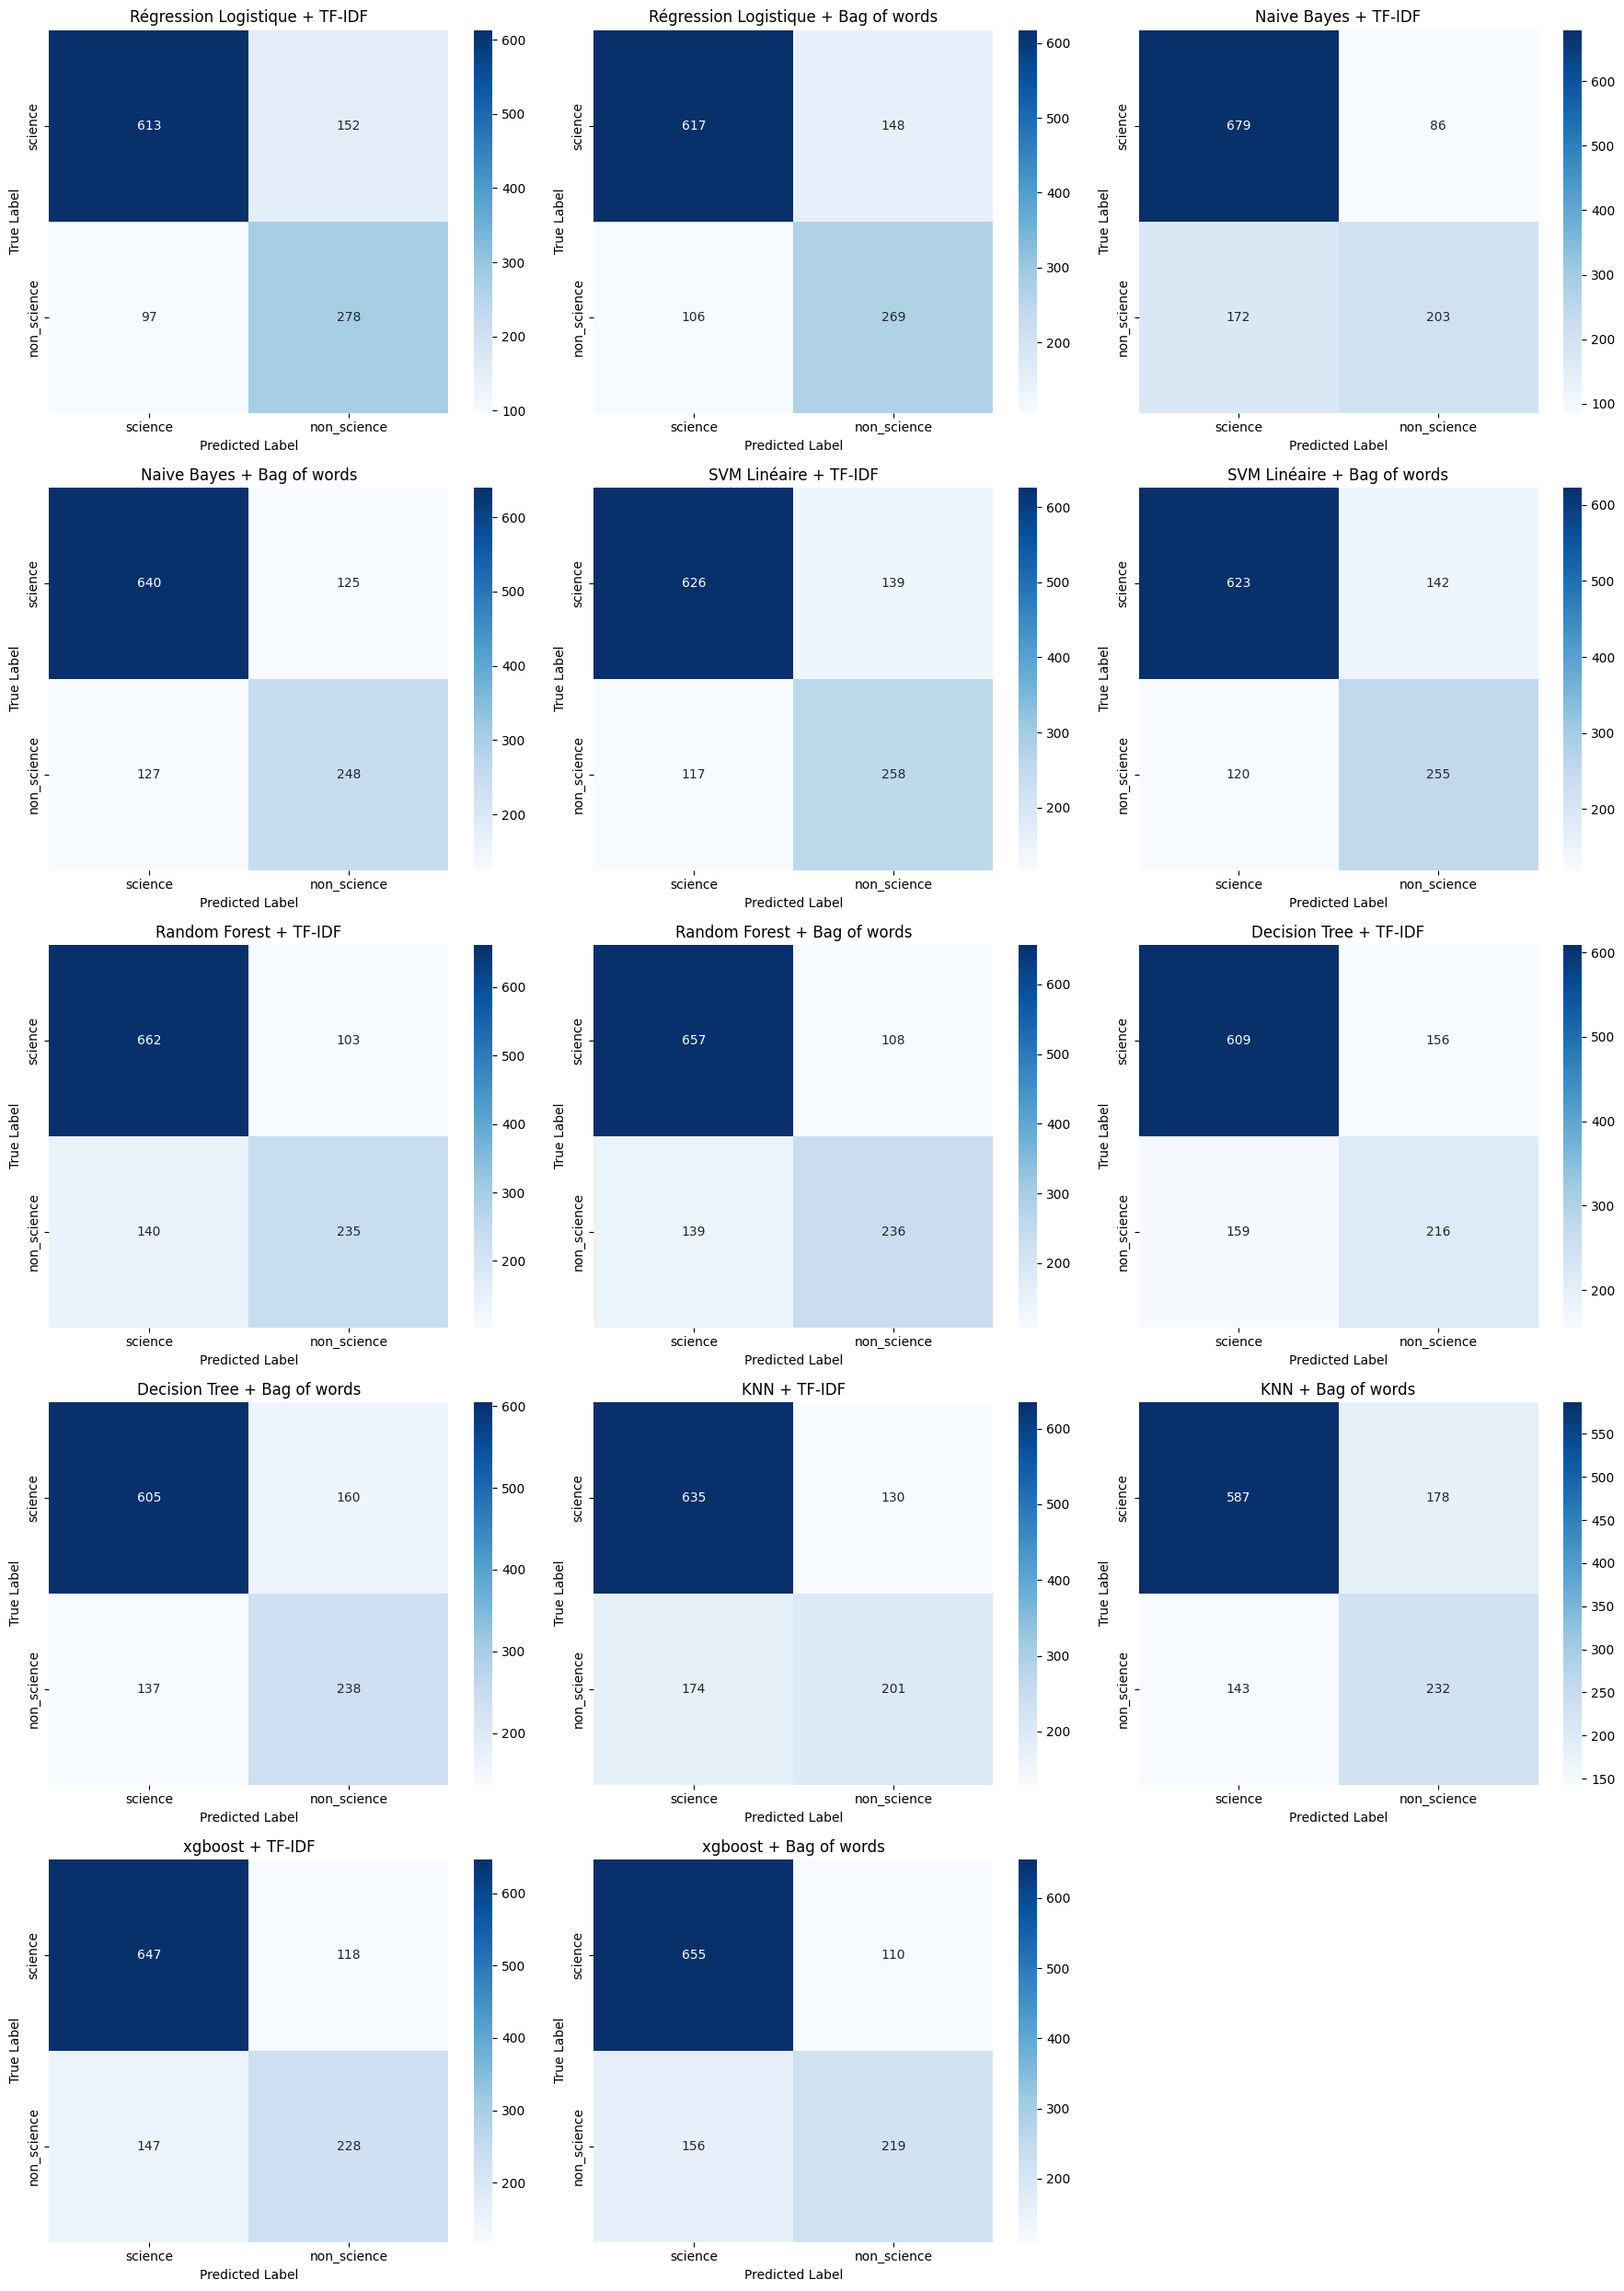

,Classifier,Vectorizer,F1 Mean,F1 Std
0,Régression Logistique,TF-IDF,0.760,0.032
1,Régression Logistique,Bag of words,0.754,0.042
6,Random Forest,TF-IDF,0.750,0.044
3,Naive Bayes,Bag of words,0.749,0.030
4,SVM Linéaire,TF-IDF,0.749,0.035
7,Random Forest,Bag of words,0.747,0.048
5,SVM Linéaire,Bag of words,0.742,0.042
12,xgboost,TF-IDF,0.731,0.034
2,Naive Bayes,TF-IDF,0.725,0.022
13,xgboost,Bag of words,0.725,0.037


In [13]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X, y,  KeywordFeatures(15, verbose=False), config, ["science", "non_science"],)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

# Tuning des hyperparamètres des 3 classifiers
1. Naive Bayes & Bag of words
2. Régression Logistique & Bag of words
3. Random Forest & Bag of words

#### Définitions de fonctions

In [14]:
ngram_options = {
	"unigram": (1, 1),
	"bigram": (1, 2),
	"trigram": (1, 3),
	"quadrugram": (1, 4)
}
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()
text_col = "text"

In [15]:
def visualize_data_with_pca(X_test, y_test, pipeline, title="PCA des données", n_components = 2):
	"""
	Visualise les données transformées avec PCA et colore par classe
	"""
	# 1. Transformer les données avec le préprocesseur du pipeline
	preprocessor = pipeline.named_steps['preprocessor']
	X_transformed = preprocessor.transform(X_test)
	
	# Si la matrice est sparse, la convertir en dense
	if hasattr(X_transformed, "toarray"):
		X_dense = X_transformed.toarray()
	else:
		X_dense = X_transformed
	
	# 2. Appliquer PCA pour réduire à 2 dimensions
	pca = PCA(n_components=n_components)
	X_pca = pca.fit_transform(X_dense)
	
	# 3. Créer un DataFrame pour la visualisation
	df_plot = pd.DataFrame({
		'PC1': X_pca[:, 0],
		'PC2': X_pca[:, 1],
		'Class': y_test.values
	})
	
	# 4. Visualiser avec un scatter plot
	plt.figure(figsize=(10, 8))
	sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Class', 
				   palette={0: "red", 1: "blue"},s=60)
	
	# 5. Ajouter des informations sur la variance expliquée
	explained_var = pca.explained_variance_ratio_
	plt.xlabel(f'PC1 ({explained_var[0]:.2%} variance expliquée)')
	plt.ylabel(f'PC2 ({explained_var[1]:.2%} variance expliquée)')
	plt.title(f'{title}\nVariance totale expliquée: {sum(explained_var):.2%}')
	
	# 6. Ajouter une légende
	plt.legend(title="Classe", labels=["Non-scientifique", "Scientifique"])
	
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.plot()

	return X_pca

from sklearn.utils import resample

def get_score(pipeline, n_iterations=100):
    f1_scores = []
    
    for i in range(n_iterations):
        indices = resample(range(len(X_test)), replace=True, n_samples=len(X_test))
        X_boot = X_test.iloc[indices] if hasattr(X_test, 'iloc') else X_test[indices]
        y_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]

        y_pred = pipeline.predict(X_boot)
        f1 = f1_score(y_boot, y_pred, average='macro')
        f1_scores.append(f1)
    
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    print(f"✅ F1-score (bootstrap sur test, {n_iterations} itérations): {f1_mean:.3f} ± {f1_std:.3f}")
    return f1_mean, f1_std

def get_vectorizer(vectorizer_type, ngram_key, min_df, max_features):
	if vectorizer_type == "tfidf":
		return TfidfVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)
	return CountVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)

def get_trial_score(classifier, vectorizer, n_keywords, scaling = True):
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, "text"),
			("num", StandardScaler() if scaling else "passthrough", numerical_cols)
		]
	)
	
	pipeline = Pipeline([
		("keywords", KeywordFeatures(n_keywords)),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	return  cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()


def get_pipeline(model, classifier, scaler = True):
	vectorizer = model.get_vectorizer()
	numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

	
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, text_col),
			("num", StandardScaler() if scaler else "passthrough", numerical_cols)
		]
	)

	return Pipeline([
		("keywords", KeywordFeatures(model.get_config("n_keywords"))),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

#### Naive Bayes avec Bag of words

In [16]:
def objective(trial):
	alpha = trial.suggest_float("alpha", 1e-3, 2.0, log=True)
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	 

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(MultinomialNB(alpha=alpha), vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 18:47:35,666] A new study created in memory with name: no-name-92d92ba5-3ad1-4940-bcdf-3b8f9e456c61


In [18]:
study.optimize(objective, n_trials=50)
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("NB", study.best_params)

[I 2025-05-06 18:48:37,089] Trial 50 finished with value: 0.7495179094913963 and parameters: {'alpha': 0.09746023628938642, 'ngram_range': 'quadrugram', 'min_df': 2, 'max_features': 16000, 'n_keywords': 10, 'vectorizer_type': 'bow'}. Best is trial 36 with value: 0.7621412712347954.
[I 2025-05-06 18:48:37,723] Trial 51 finished with value: 0.7597433417503066 and parameters: {'alpha': 0.3277571047926348, 'ngram_range': 'quadrugram', 'min_df': 1, 'max_features': 11000, 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 36 with value: 0.7621412712347954.
[I 2025-05-06 18:48:38,476] Trial 52 finished with value: 0.7654687721142155 and parameters: {'alpha': 0.261747369036102, 'ngram_range': 'quadrugram', 'min_df': 1, 'max_features': 12000, 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 52 with value: 0.7654687721142155.
[I 2025-05-06 18:48:39,176] Trial 53 finished with value: 0.7571649088435524 and parameters: {'alpha': 0.22202335739138812, 'ngram_range': 'quadrugram', '

Best f1_macro: 0.7689224187744116
Best params: {'alpha': 0.09214926840159884, 'ngram_range': 'trigram', 'min_df': 1, 'max_features': 14000, 'n_keywords': 10, 'vectorizer_type': 'bow'}
✅  Model (NB) saved in config file


On ajoute ce modele dans le config file

✅ F1-score (bootstrap sur test, 100 itérations): 0.771 ± 0.027


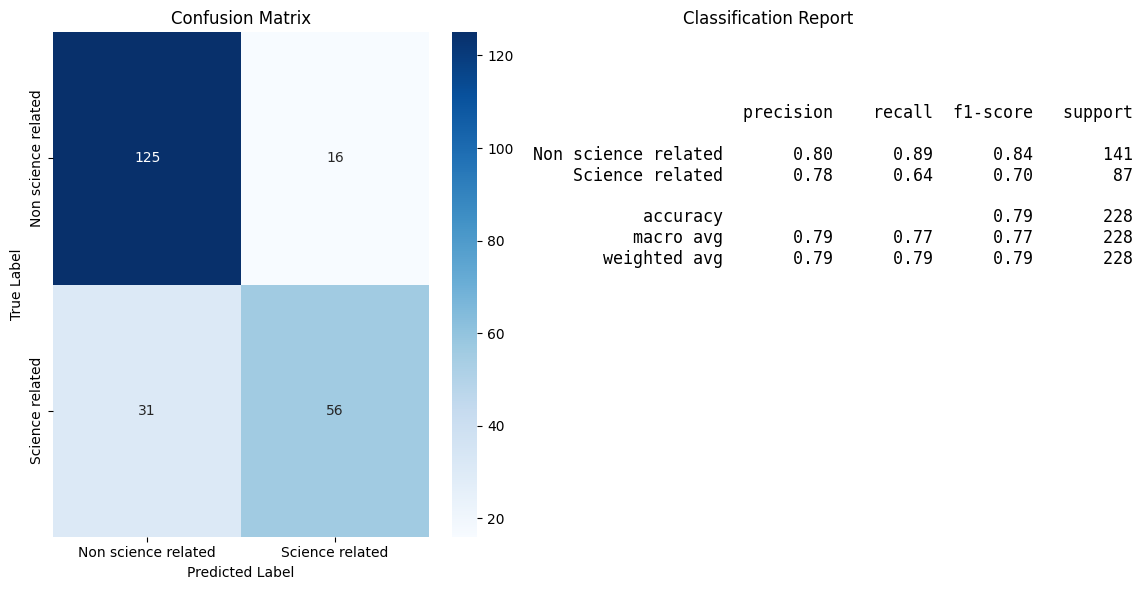

✅ Results saved to: ../results/Step1/NB


In [42]:
model = config.get_model("NB")
classifier = MultinomialNB(alpha=model.get_config("alpha"))
pipeline_NB = get_pipeline(model, classifier, scaler=False)


pipeline_NB.fit(X_train, y_train)
y_pred = pipeline_NB.predict(X_test)

f1_m, f1_std = get_score(pipeline_NB)
fig = display_result(y_pred, y_test)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)


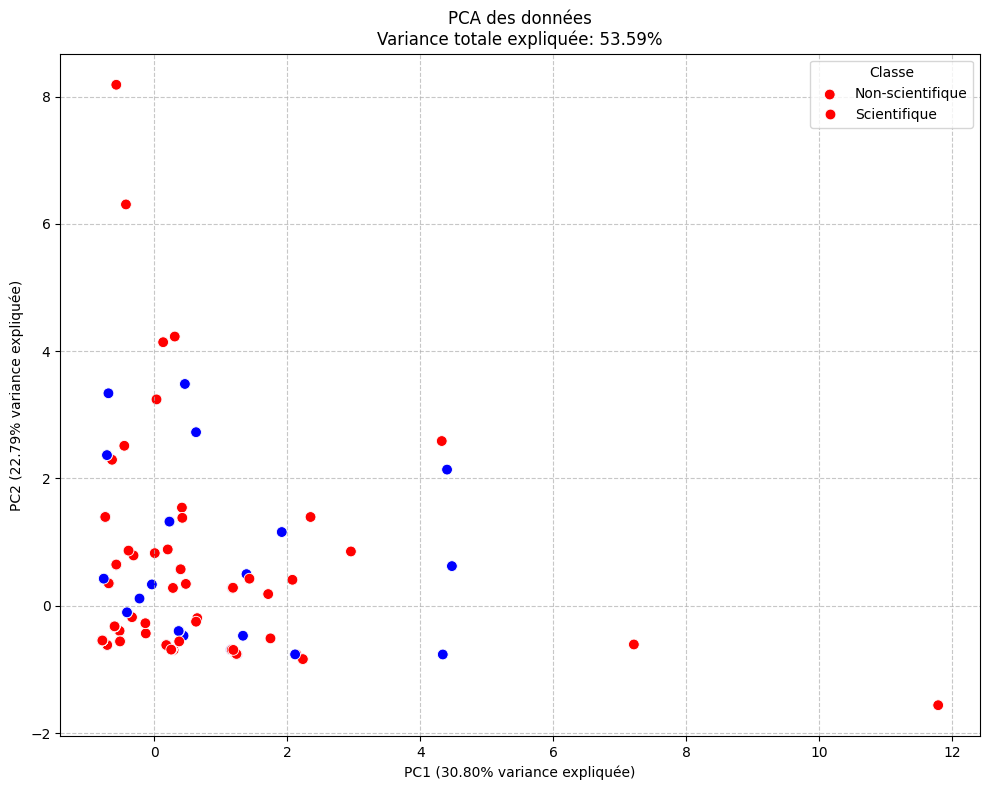

In [24]:
reduced_data = visualize_data_with_pca(X_test, y_test, pipeline_NB)

#### Random Forest avec Bag of words

In [28]:
def objective(trial):
	# Hyperparamètres texte
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Random Forest
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 5, 50)
	min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

	bootstrap = trial.suggest_categorical("bootstrap", [True, False])
	max_features_model = trial.suggest_categorical("max_features_model", ['sqrt', 'log2', None])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)

	classifier = RandomForestClassifier(
		n_estimators=n_estimators,
		max_depth=max_depth,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		random_state=config.random_state,
		max_features= max_features_model,
		bootstrap = bootstrap,
		class_weight='balanced'
	)

	
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 18:57:13,128] A new study created in memory with name: no-name-a48d9e12-c059-474e-9bf7-e1c671b203b8


In [29]:
study.optimize(objective, n_trials=200)
print("✅ Best f1_macro:", study.best_value)
print("✅ Best params:", study.best_params)
config.save_model("RandomForest", study.best_params)

[I 2025-05-06 18:57:28,829] Trial 0 finished with value: 0.6952351713452866 and parameters: {'ngram_range': 'unigram', 'min_df': 6, 'max_features': 18000, 'n_estimators': 300, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features_model': None, 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 0 with value: 0.6952351713452866.
[I 2025-05-06 18:57:33,470] Trial 1 finished with value: 0.7263269079903384 and parameters: {'ngram_range': 'unigram', 'min_df': 5, 'max_features': 6000, 'n_estimators': 800, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features_model': 'sqrt', 'n_keywords': 30, 'vectorizer_type': 'bow'}. Best is trial 1 with value: 0.7263269079903384.
[I 2025-05-06 18:57:34,447] Trial 2 finished with value: 0.759504027648227 and parameters: {'ngram_range': 'unigram', 'min_df': 2, 'max_features': 16000, 'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1,

✅ Best f1_macro: 0.7640428478325827
✅ Best params: {'ngram_range': 'unigram', 'min_df': 2, 'max_features': 11000, 'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features_model': 'log2', 'n_keywords': 10, 'vectorizer_type': 'bow'}
✅  Model (RandomForest) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.816 ± 0.028


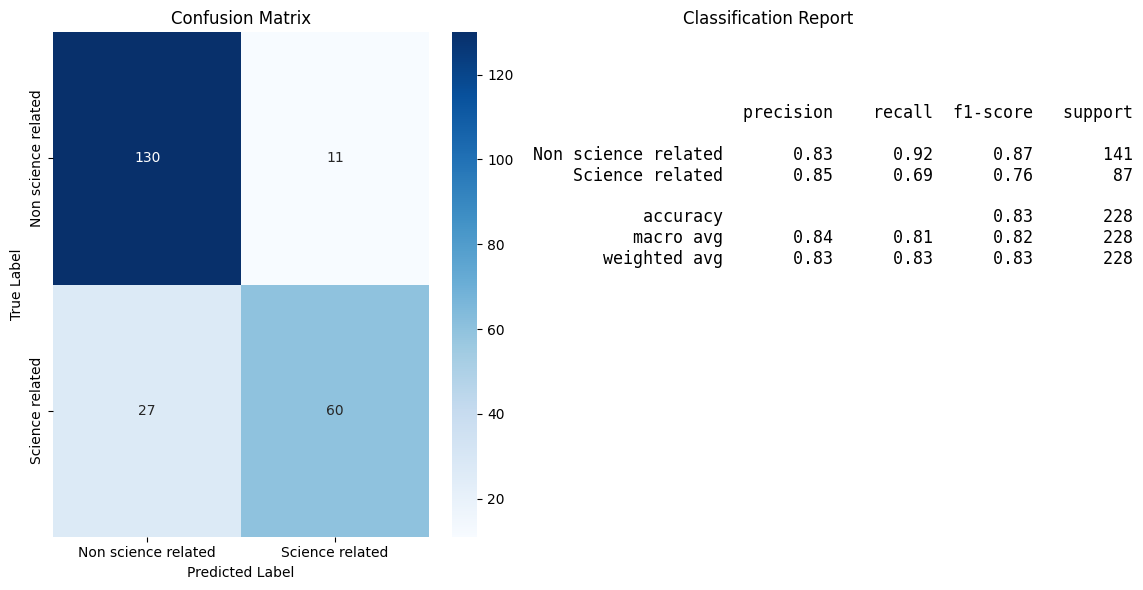

✅ Results saved to: ../results/Step1/RandomForest


In [41]:
model = config.get_model("RandomForest")

classifier = RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		bootstrap = model.get_config("bootstrap"),
		max_features = model.get_config("max_features_model"),
		random_state = config.random_state,
		class_weight='balanced'
	)

pipeline_RF = get_pipeline(model, classifier, scaler=False)

pipeline_RF.fit(X_train, y_train)
y_pred = pipeline_RF.predict(X_test)


f1_m, f1_std = get_score(pipeline_RF)
fig = display_result(y_pred, y_test)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)


#### Regression Logistique avec Bag of Words

In [31]:
def objective(trial):
	
	# Hyperparamètres texte
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-4, 100.0, log=True)
	penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
	solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)

	if penalty == "l1" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()

	if penalty == "l2" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()
	

	classifier = LogisticRegression(
		C=C,
		penalty=penalty,
		solver=solver,
		random_state=config.random_state,
		class_weight='balanced',
		max_iter=8000
	)

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow", "tfidf"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 19:09:21,984] A new study created in memory with name: no-name-849e9b6c-69e8-4814-bfb2-68bf8c2069da


In [32]:
study.optimize(objective, n_trials=50)
print("✅ Best f1_macro:", study.best_value)
print("🏆 Best hyperparameters:", study.best_params)

config.save_model("LogisticRegression", study.best_params)

[I 2025-05-06 19:09:51,002] Trial 0 finished with value: 0.7353157774732103 and parameters: {'ngram_range': 'bigram', 'min_df': 2, 'max_features': 8000, 'C': 32.82348898858274, 'penalty': 'l1', 'solver': 'saga', 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 0 with value: 0.7353157774732103.
[I 2025-05-06 19:09:51,643] Trial 1 finished with value: 0.6518283866640017 and parameters: {'ngram_range': 'bigram', 'min_df': 3, 'max_features': 10000, 'C': 0.010475176669525656, 'penalty': 'l2', 'solver': 'saga', 'n_keywords': 20, 'vectorizer_type': 'bow'}. Best is trial 0 with value: 0.7353157774732103.
[I 2025-05-06 19:09:53,496] Trial 2 finished with value: 0.7249670317433776 and parameters: {'ngram_range': 'bigram', 'min_df': 5, 'max_features': 19000, 'C': 62.992287787948534, 'penalty': 'l2', 'solver': 'saga', 'n_keywords': 10, 'vectorizer_type': 'tfidf'}. Best is trial 0 with value: 0.7353157774732103.
[I 2025-05-06 19:09:54,709] Trial 3 finished with value: 0.406087202514009 an

✅ Best f1_macro: 0.7657238835801662
🏆 Best hyperparameters: {'ngram_range': 'bigram', 'min_df': 1, 'max_features': 5000, 'C': 5.668605010092585, 'penalty': 'l2', 'solver': 'saga', 'n_keywords': 10, 'vectorizer_type': 'tfidf'}
✅  Model (LogisticRegression) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.791 ± 0.028


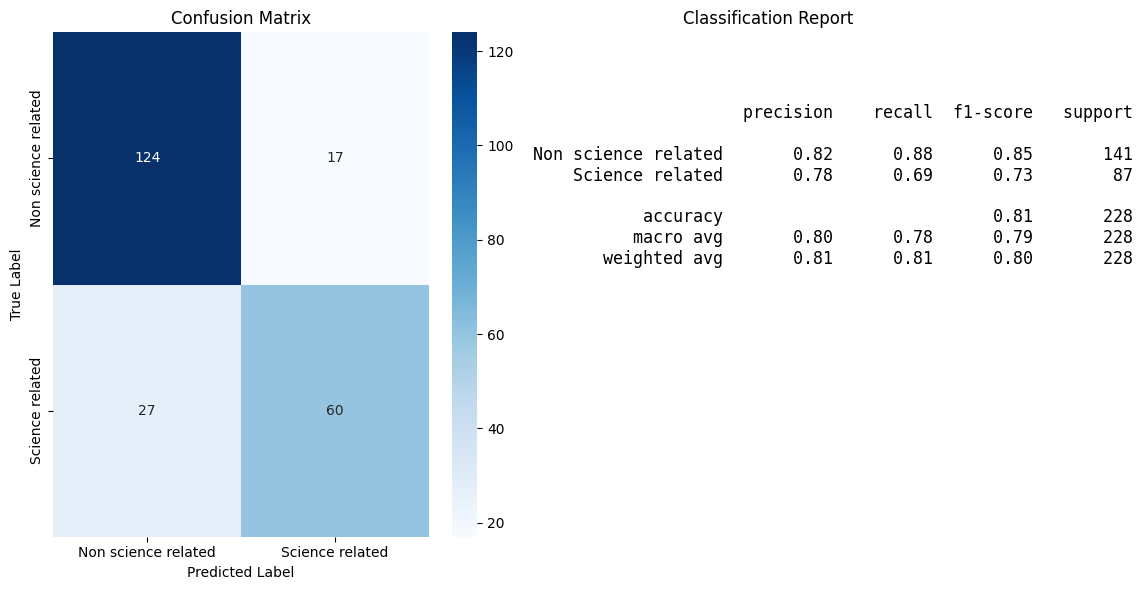

✅ Results saved to: ../results/Step1/LogisticRegression


In [33]:
model = config.get_model("LogisticRegression")
classifier = LogisticRegression(
        C = model.get_config("C"),
            penalty = model.get_config("penalty"),
        solver = model.get_config("solver"),
        class_weight = "balanced",
        random_state = config.random_state,
        max_iter = 8000
    )

pipelineLR = get_pipeline(model, classifier, scaler=True)

pipelineLR.fit(X_train, y_train)
y_pred = pipelineLR.predict(X_test)

f1_m, f1_std = get_score(pipelineLR)
fig = display_result(y_pred, y_test)
save_result(
	title="Rapport du Regression Logistique avec TF-IDF",
	description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
	fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)

#### Linear SVC

In [36]:
from sklearn.svm import LinearSVC

def objective(trial):
	# Hyperparamètres texte
	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-4, 100.0, log=True)
	loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
	dual = trial.suggest_categorical("dual", [True, False])

	if loss == "hinge" and dual is False:
		raise optuna.exceptions.TrialPruned()

	classifier = LinearSVC(
		C=C,
		loss=loss,
		dual=dual,
		random_state=config.random_state,
		max_iter=40_000,
		class_weight="balanced"
	)

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:19:21,902] A new study created in memory with name: no-name-b18b5e2d-f872-4319-ba14-b949af712ca6


In [37]:
study.optimize(objective, n_trials=100)
print("✅ Best f1_macro:", study.best_value)
print("🏆 Best hyperparameters:", study.best_params)

config.save_model("LinearSVC", study.best_params)

[I 2025-05-06 19:19:24,852] Trial 0 pruned. 
[I 2025-05-06 19:19:24,856] Trial 1 pruned. 
[I 2025-05-06 19:19:25,237] Trial 2 finished with value: 0.746613597458263 and parameters: {'n_keywords': 15, 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 8000, 'C': 0.19138555943232416, 'loss': 'squared_hinge', 'dual': False, 'vectorizer_type': 'tfidf'}. Best is trial 2 with value: 0.746613597458263.
[I 2025-05-06 19:19:25,241] Trial 3 pruned. 
[I 2025-05-06 19:19:25,245] Trial 4 pruned. 
[I 2025-05-06 19:19:25,911] Trial 5 finished with value: 0.7243235401037756 and parameters: {'n_keywords': 30, 'ngram_range': 'trigram', 'min_df': 8, 'max_features': 17000, 'C': 28.00968286588837, 'loss': 'squared_hinge', 'dual': False, 'vectorizer_type': 'tfidf'}. Best is trial 2 with value: 0.746613597458263.
[I 2025-05-06 19:19:25,915] Trial 6 pruned. 
[I 2025-05-06 19:19:26,329] Trial 7 finished with value: 0.7079008771395849 and parameters: {'n_keywords': 25, 'ngram_range': 'unigram', 'min_df': 9,

✅ Best f1_macro: 0.7660104657434849
🏆 Best hyperparameters: {'n_keywords': 15, 'ngram_range': 'bigram', 'min_df': 1, 'max_features': 6000, 'C': 0.5410053364325239, 'loss': 'squared_hinge', 'dual': True, 'vectorizer_type': 'tfidf'}
✅  Model (LinearSVC) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.794 ± 0.027


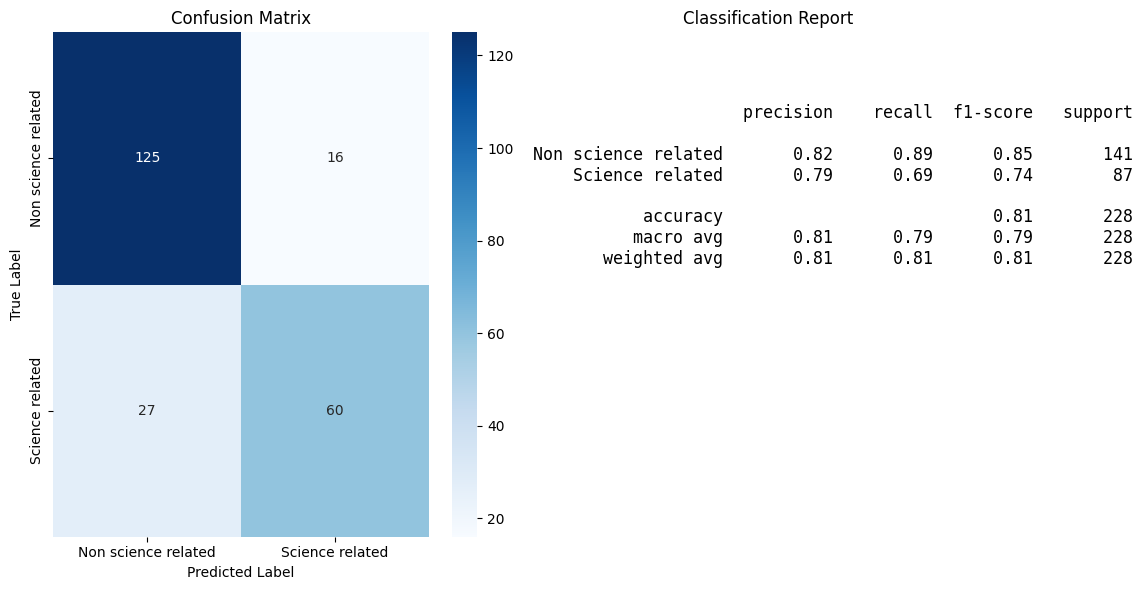

✅ Results saved to: ../results/Step1/LinearSVC


In [38]:
model = config.get_model("LinearSVC")
classifier = LinearSVC(
		C=model.get_config("C"),
		loss=model.get_config("loss"),
		dual=model.get_config("dual"),
		random_state=config.random_state,
		max_iter=40_000,
		class_weight="balanced"
	)

pipeline = get_pipeline(model, classifier, scaler=True)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f1_m, f1_std = get_score(pipeline)

fig = display_result(y_pred, y_test)
save_result(
	title= f"Rapport du {model.name} avec TF-IDF",
	description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
	fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)

# Evaluation des modèles

In [39]:
importances = pipeline_RF.named_steps['classifier'].feature_importances_
features = pipeline_RF.named_steps['preprocessor'].get_feature_names_out()
feature_importances = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances[:20]: 
	print(f"{feature}: {importance:.4f}")

text__stop: 0.0352
num__link_count: 0.0320
text__url: 0.0251
text__study: 0.0198
num__emoji_count: 0.0143
text__mention: 0.0133
text__health: 0.0120
text__support: 0.0111
text__need: 0.0070
text__research: 0.0069
text__scientist: 0.0066
num__mention_count: 0.0066
text__report: 0.0064
text__change: 0.0064
text__cancer: 0.0060
text__cell: 0.0054
text__help: 0.0052
text__man: 0.0051
text__effect: 0.0049
text__use: 0.0048
